# Playing around with popular nonlinear classification algorithms

In the next Python cell we load in several necessary libraries.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ipywidgets import interact
from ipywidgets import widgets

The next Python cell contains a simple function for loading in a two-class classification dataset and plotting it.  Data from each class are colored (red and green, respectively) so that we can visually distinguish between them.

In [4]:
def load_pts(csv_name): 
    # load data
    data = np.asarray(pd.read_csv(csv_name,header = None))
    X = data[:,0:2]
    y = data[:,2]

    # plot our points (Colors were flipped on original file)
    green = [0.25,1,0.5]  # custom color for plotting purposes
    red = [1,0.3,0.3]     # custom color for plotting purposes
    plt.scatter(X[np.argwhere(y==0).flatten(),0],X[np.argwhere(y==0).flatten(),1],s = 50, color = green, edgecolor = 'k')
    plt.scatter(X[np.argwhere(y==1).flatten(),0],X[np.argwhere(y==1).flatten(),1],s = 50, color = red, edgecolor = 'k')

    # dress panel correctly with axis labels etc.
    plt.xlim(-0.05,1.05)
    plt.ylim(-0.05,1.05)
    plt.grid(False)
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off')         # ticks along the top edge are off

    return X,y

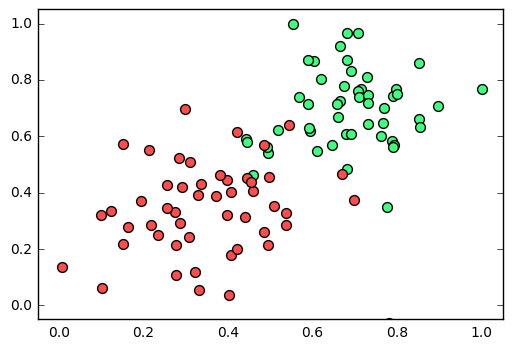

In [5]:
# use the plotting function to visualize our data
X,y = load_pts('files/2class_overlap.csv')

### Algorithm 1: linear Support Vector Machine

Now lets learn a nonlinear classifier to distinguish between the two classes.  For this task there are many choices (as discussed in the nanodegree intro video), and in this demonstration notebook we will examine: Support Vector Machines, and neural networks, and decision trees.  You will learn much more about these algorithms throughout the Machine Learning Nanodegree program!

For our first demonstration we will use a linear Support Vector Machine (SVM) model - a model that seeks to find the best line to separate the two classes of data. 

In what follows will get to play around with the value of the SVM parameter 'C' to find a line that gives a good fit to the dataset.  The following Python cell contains a function for running the SVM  algorithm and with a wide array of choices for this parameter.

In [6]:
# a general purpose function for running and plotting the result of a user-defined input classification algorithm
def browse_vals(X,y,clf,param_name,slider_min,slider_max,slider_start):
    def show_fit(parameter_value):
        # set parameter value of classifier
        exec 'clf.' + param_name + ' = ' +  str(parameter_value) in locals(),globals()

        # fit classifier
        clf.fit(X,y)

        # plot our points (again, colors flipped)
        green = [0.25,1,0.5]  # custom color for plotting purposes
        red = [1,0.3,0.3]     # custom color for plotting purposes
        plt.scatter(X[np.argwhere(y==0).flatten(),0],X[np.argwhere(y==0).flatten(),1],s = 50, color = green, edgecolor = 'k')
        plt.scatter(X[np.argwhere(y==1).flatten(),0],X[np.argwhere(y==1).flatten(),1],s = 50, color = red, edgecolor = 'k')

        # dress panel correctly with axis labels etc.
        plt.xlim(-0.05,1.05)
        plt.ylim(-0.05,1.05)
        plt.grid(False)
        plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off')         # ticks along the top edge are off

        # plot classification boundary and color regions appropriately
        r = np.linspace(-0.1,1.1,300)
        s,t = np.meshgrid(r,r)
        s = np.reshape(s,(np.size(s),1))
        t = np.reshape(t,(np.size(t),1))
        h = np.concatenate((s,t),1)

        # use classifier to make predictions
        z = clf.predict(h)

        # reshape predictions for plotting
        s.shape = (np.size(r),np.size(r))
        t.shape = (np.size(r),np.size(r))
        z.shape = (np.size(r),np.size(r))

        # show the filled in predicted-regions of the plane 
        plt.contourf(s,t,z,colors = [green,red],alpha = 0.2,levels = range(-1,2))

        # show the classification boundary if it exists
        if len(np.unique(z)) > 1:
            plt.contour(s,t,z,colors = 'k',linewidths = 2)
    
    interact(show_fit, parameter_value=widgets.IntSlider(min=slider_min,max=slider_max,step=1,value=slider_start))

Once this function is run a simple slider mechanism will pop up that allows you to define the 'C' parameter yourself.  Once the slider is placed in a given position the function in the Python cell above trains a corresponding model - in this case an SVM - to the dataset.  

As you will by running the following Python cell, the default value for C set on the slider does not provide good results.  Try moving the slider around to see if you can find an ideal value for C.  

Note: here the classification boundary itself is drawn in black, while each region colored in light green and light red represent those points that the learned classifier predicts are of class green and red respectively.

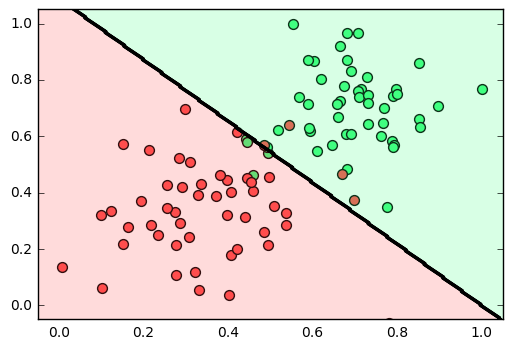

In [10]:
# create the linear SVM classifier and plug it into the previous Python function
from sklearn.svm import SVC
clf = SVC(kernel = 'linear')
browse_vals(X,y,clf,'C',slider_min = 1,slider_max = 10,slider_start = 1) 

## Algorithm 2: kernelized Support Vector Machine

Now lets look at a different dataset and try the same thing!  That is, lets load up another dataset and play around with the C value to see if we can determine its best value using the slider mechanism we used previously.

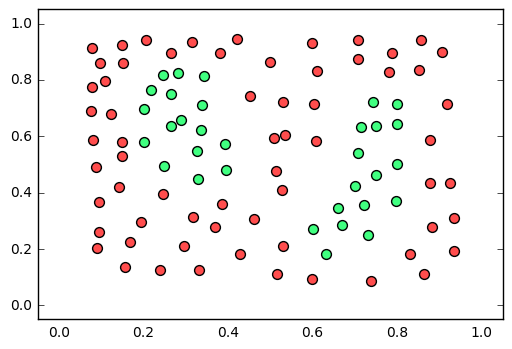

In [11]:
# use the plotting function to visualize our data
X,y = load_pts('files/2eggs_data.csv')

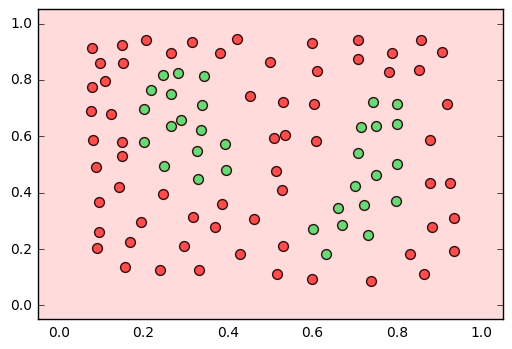

In [12]:
# create the linear SVM classifier and plug it into the parameter-testing function
clf = SVC(kernel = 'linear')
browse_vals(X,y,clf,'C',slider_min = 1,slider_max = 10,slider_start = 1) 

Playing around with the value of C here does not seem to change anything!  To begin with the two classes cannot be easily separated by a line, but in addition because there are far more points in the green class than in the red class (twice as many to be accurate) the 'best' line here always classifies the entire dataset as green!

However we can clearly see that the two classes are distinguishable - not by a line, but by a series of closed curves.  To find these curves we need to employ a number of other methods: including an adaptation of the linear SVM above known as *kernelized Support Vector Machines*.

For our next demonstration we will use one such kernelized SVM model to learn a good nonlinear boundary between the two classes.  There are many kernels one can choose from, but here we will employ the commonly used [Radial Basis Function kernel](https://www.udacity.com/course/intro-to-machine-learning--ud120), or RBF kernel for short.

This model once again has a single parameter - this time called 'gamma'.  In the following Python cell we plug this kernelized SVM model into our Python slider function.  

Play around with the gamma value by moving the slider around until you find a good value for the parameter.  Question: what happens if you make the parameter too small or too large in terms of the classification result?

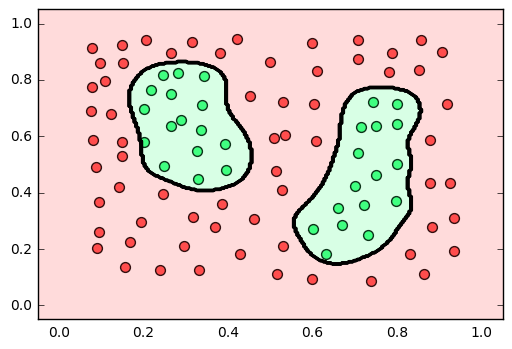

In [13]:
# create the linear SVM classifier and plug it into the parameter-testing function
clf = SVC(kernel = 'rbf')
browse_vals(X,y,clf,'gamma',slider_min = 1,slider_max = 1000,slider_start = 5) 

A value of gamma around 100 seems to distinguish between the two classes fairly well, assigning most of the points around each of the two red point clouds to the red class (with everything else classified as green).

Notice how when a small value for the parameter gamma is chosen (e.g., gamma = 5) the nonlinear boundary learned doesn't quite distinguish between the two classes as well as we would like.  This (clearly undesirable) phenomenon is generally referred to as *underfitting* in machine learning.

Conversely, notice that for too large a value of gamma (e.g., gamma = 1000) each individual point in the red class is tightly classified by a surrounding boundary.  This is undesirable as well because the model won't generalize very well- here many points inside each red-point cloud will be classified as green, which is off.  This (undesirable) phenomenon is referred to as *overfitting* in machine learning.

### Algorithm 3: Neural networks

[Neural networks](https://www.udacity.com/course/intro-to-machine-learning--ud120) are another class of nonlinear classification algorithms one can apply to the dataset above.  Lets perform a similar same experiment with a neural network classifier where we plug in the model into our slider mechanism, and play around with one of its important parameters - here called 'hidden_layer_sizes'.  

As you play with this parameter value notice how - generally -  the shape of the boundary learned via neural networks looks quite different than that of the kernelized SVM model.

As with the kernelized SVM - can you determine value(s) of this parameter that provide a good or bad fit to the dataset?  Or, in machine learning lingo, fit the dataset well or either underfit or overfit the data?

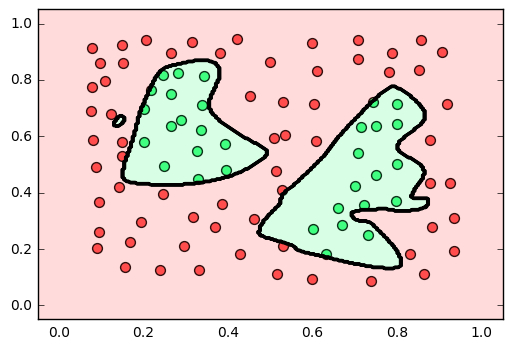

In [15]:
''' Note: neural nets are currently available only in version 0.18dev of scikit . 
    To get this version simply
    - install scikit + dependencies via Aanaconda
    - run: pip install scikit-learn==0.18.rc2 at terminal / in Dockerfile
'''
from sklearn.neural_network import MLPClassifier
# Error from solver. Change from 'lbgfs' to 'lbfgs'
clf = MLPClassifier(solver = 'lbfgs',alpha = 0,activation = 'tanh',random_state = 1)
browse_vals(X,y,clf,'hidden_layer_sizes',slider_min = 1,slider_max = 200,slider_start = 10) 

### Algorithm 4: decision trees

[The decision tree classifier](https://www.udacity.com/course/intro-to-machine-learning--ud120) is another nonlinear classification scheme you will learn about in the Machine Learning Nanodegree program.  Unlike e.g., a kernelized SVM or neural networks model, the boundary of a decision tree consists of segments which are paralell to the axes of the data.  This is considerably different than what we have already seen with kernelized SVM and neural networks - each of which produced smooth seperating boundaries between the green and red classes.

Try applying the decision tree function to the dataset above, varying an important decision tree parameter - called 'max_depth' - using the slider mechanism we have used previously.  Which values of this parameter tend to provide good versus bad classification accuracy?

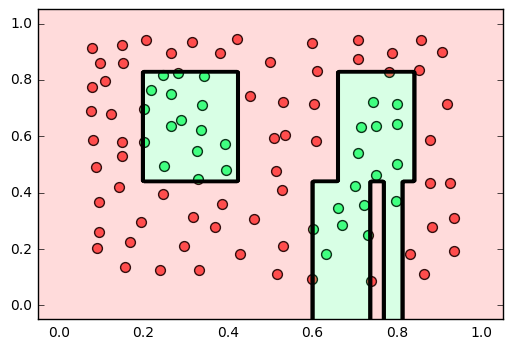

In [16]:
# run the Python slider function using the decision tree classifier - here the parameter to adjust is referred to as 'max_depth'
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
browse_vals(X,y,clf,'max_depth',slider_min = 1,slider_max = 10,slider_start = 2) 